In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap

### **Importing Training/Testing Features and Labels Data**


*   80/20 train-test split

*   Each sample is a 64 x 64 pixel grid (each pixel representing 1 km) for 8 layers of environmental raster variables:
    * Monthly Maximum Temperature
    * Monthly Minimum Temperature
    * Monthly Total Precipitation
    * Annual Glyphosate Use
    * Elevation
    * Nonforested Primary Land Cover
    * Agricultural Land Cover
    * Urban Land Cover






In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train_fall_s = np.load('/content/drive/MyDrive/Train Test Data/X_train_fall_s.npy')
X_test_fall_s = np.load('/content/drive/MyDrive/Train Test Data/X_test_fall_s.npy')
y_train_fall_s = np.load('/content/drive/MyDrive/Train Test Data/y_train_fall_s.npy')
y_test_fall_s = np.load('/content/drive/MyDrive/Train Test Data/y_test_fall_s.npy')

In [4]:
X_train_fall_s = np.transpose(X_train_fall_s, (0, 2, 3, 1))
X_train_fall_s.shape

(3284, 64, 64, 8)

In [5]:
X_test_fall_s = np.transpose(X_test_fall_s, (0, 2, 3, 1))
X_test_fall_s.shape

(821, 64, 64, 8)

In [6]:
y_train_fall_s.shape

(3284,)

In [7]:
y_test_fall_s.shape

(821,)

### **Training the Convolutional Neural Network Species Distribution (CNN-SDM) Model**

In [8]:
model_fall_s = Sequential()

# Input layer: 64x64 spatial grid with 8 channels
model_fall_s.add(tf.keras.layers.Input(shape = (64, 64, 8)))

# First convolutional and pooling layer: Detect basic patterns with 16 filters
model_fall_s.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
model_fall_s.add(MaxPool2D(pool_size = (2, 2)))

# Second convolutional and pooling layer: Learn more complex patterns with 32 filters
model_fall_s.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model_fall_s.add(MaxPool2D(pool_size = (2, 2)))

# Flatten spatial features for dense classification layer
model_fall_s.add(Flatten())

# Output layer: Binary classification with sigmoid activation
model_fall_s.add(Dense(1, activation = 'sigmoid'))

# Compile model: Binary cross-entropy loss function, Adam adaptive learning optimization algorithm, performance metric tracking
model_fall_s.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall()])

# Display architecture summary: ~12,000 parameters
model_fall_s.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,081 (47.19 KB)

 Trainable params: 12,081 (47.19 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history_fall_s = model_fall_s.fit(X_train_fall_s, y_train_fall_s, epochs = 10, validation_data = (X_test_fall_s, y_test_fall_s))

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.8106 - loss: 0.3682 - recall: 0.7475 - val_accuracy: 0.9403 - val_loss: 0.1632 - val_recall: 0.9138
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9572 - loss: 0.1276 - recall: 0.9434 - val_accuracy: 0.9415 - val_loss: 0.1611 - val_recall: 0.9138
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9567 - loss: 0.1210 - recall: 0.9450 - val_accuracy: 0.9354 - val_loss: 0.1749 - val_recall: 0.8974
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.9574 - loss: 0.1247 - recall: 0.9404 - val_accuracy: 0.9525 - val_loss: 0.1338 - val_recall: 0.9371
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9690 - loss: 0.0958 - recall: 0.9594 - val_accuracy: 0.9488 - val_loss: 0.1393 - val_recall: 0.9347
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9607 - loss: 0.1073 - recall: 0.9504 - val_accuracy: 0.9476 - val_loss: 0.1484 - val_re

### **Evaluating Model Performance & Selecting Binary Classification Threshold**

<Axes: >

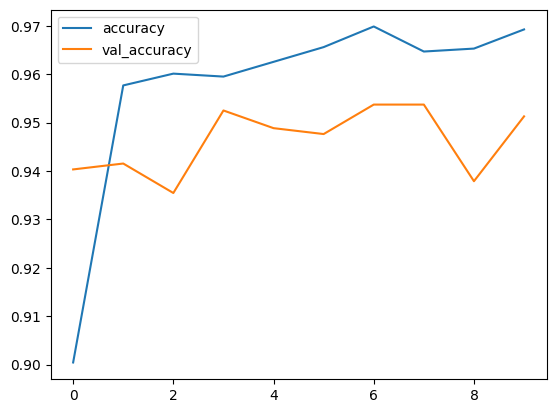

In [10]:
# Plots training and validation accuracy to assess learning trend and overfitting
losses_fall_s = pd.DataFrame(history_fall_s.history)
losses_fall_s[['accuracy', 'val_accuracy']].plot()

In [11]:
# Generates probability predictions on test set for model evaluation
y_pred_fall_s = model_fall_s.predict(X_test_fall_s)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [12]:
# Calculates false positive rate (FPR) and true positive rate (TPR) across classification thresholds
fpr_fall_s, tpr_fall_s, thresholds_fall_s = roc_curve(y_test_fall_s, y_pred_fall_s)

0.9880119880119881


/tmp/ipython-input-2352113792.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'lower right')


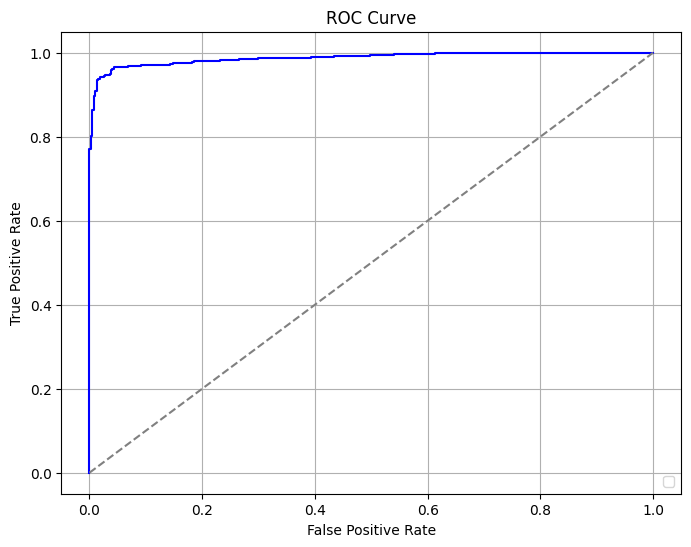

In [13]:
# Calculates the area under the Receiver Operating Characteristic curve (AUC-ROC; FPR vs TPR)
roc_auc_fall_s = auc(fpr_fall_s, tpr_fall_s)
print(roc_auc_fall_s) # AUC-ROC = 1 (perfect classifier); AUC-ROC = 0.5 (random classifer)

# Plots the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr_fall_s, tpr_fall_s, color='blue')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

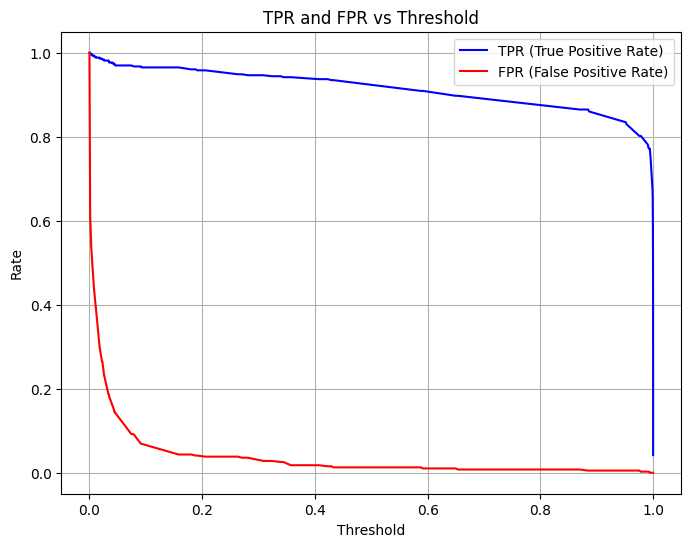

In [14]:
# Plots TPR and FPR against classification thresholds
plt.figure(figsize = (8, 6))
plt.plot(thresholds_fall_s, tpr_fall_s, label = 'TPR (True Positive Rate)', color = 'blue')
plt.plot(thresholds_fall_s, fpr_fall_s, label = 'FPR (False Positive Rate)', color = 'red')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Calculates the True Skill Statistic (TSS; TPR - FPR) to select the optimal threshold for binary classification
tss_fall_s = tpr_fall_s - fpr_fall_s
best_threshold_fall_s = thresholds_fall_s[np.argmax(tss_fall_s)]
best_tpr_fall_s = tpr_fall_s[np.argmax(tss_fall_s)]
best_fpr_fall_s = fpr_fall_s[np.argmax(tss_fall_s)]
print(best_threshold_fall_s) # TSS = 1 (perfect classifier); TSS = 0 (random guessing); TSS = -1 (perfectly wrong classifer)
print(best_tpr_fall_s) # TPR = percentage of positive cases predicting correctly
print(best_fpr_fall_s) # FPR = percentage of negative cases wrongly predicted as positive

0.3572251
0.9417249417249417
0.017857142857142856


### **Calculating Permutation Feature Importance**

In [16]:
# Compute the baseline accuracy score of the test dataset
baseline_preds = model_fall_s.predict(X_test_fall_s)
pred_labels = (baseline_preds >= best_threshold_fall_s).astype(int).flatten()
baseline = accuracy_score(y_test_fall_s, pred_labels)
print(baseline)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
0.9610231425091352


In [17]:
X_test_fall_s.shape

(821, 64, 64, 8)

In [18]:
# Variables of the 8 channels to label results
variable_names = ['Monthly Maximum Temperature', 'Monthly Minimum Temperature', 'Monthly Total Precipitation', 'Annual Glyphosate Use', 'Elevation', 'Nonforested Primary Land Cover', 'Agricultural Land Cover', 'Urban Land Cover']

# To collect mean and standard deviation (SD) of permutation importance of each channel
importances = []
importances_sd = []

# To store every permutation importance calculation with the variable and group for later plotting (see 'pi_analysis_bar_chart.ipynb')
results = {'Group': [], 'Variable': [], 'Permutation Importance': []}

# Calculate permutation importances 50 times for each variable
for channel in range(8):
  scores = []
  for _ in range(50):
    X_permuted = X_test_fall_s.copy()
    # Extracts the 64 x 64 grid of the current variable for all samples, and flatten into rows with 4096 (64 x 64) values, each row representing a sample
    flat_channel = X_permuted[:, :, :, channel].reshape(X_test_fall_s.shape[0], -1)

    # Shuffle/permute each row or sample
    np.random.shuffle(flat_channel)

    # Reshapes the samples back to 64 x 64 grids, and sets them as the new samples of the current variable in the model input tensor
    X_permuted[:, :, :, channel] = flat_channel.reshape(X_test_fall_s.shape[0], 64, 64)

    # Produce new predictions with the model using the permuted samples for the current variable
    preds = model_fall_s.predict(X_permuted)
    pred_labels = (preds >= best_threshold_fall_s).astype(int).flatten()

    # Calculate accuracy score of new predictions and calculate and record the performance drop
    score = accuracy_score(y_test_fall_s, pred_labels)
    results['Group'].append('Fall South')
    results['Variable'].append(variable_names[channel])
    results['Permutation Importance'].append(baseline - score)
    scores.append(baseline - score)

  # store the mean and standard deviation of the permutation importance for each variable
  importances.append(np.mean(scores))
  importances_sd.append(np.std(scores))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


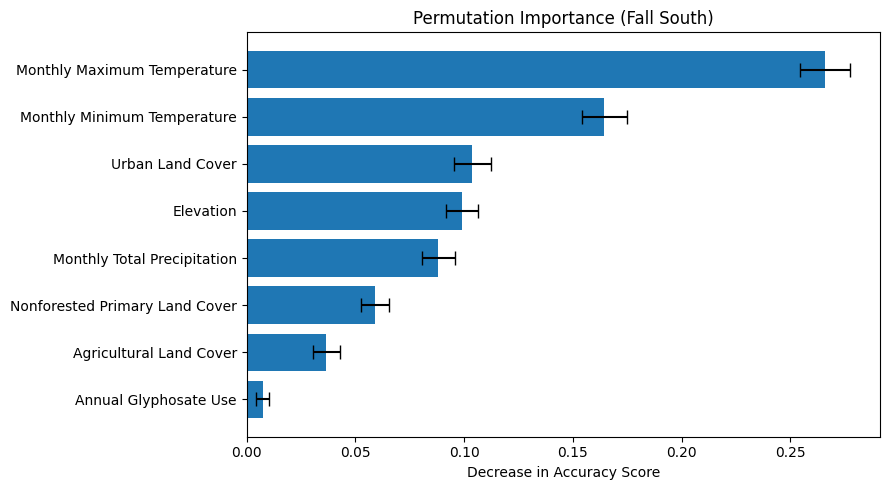

In [19]:
# Sort mean and SDs of permutation importances in ascending order
sorted_idx = np.argsort(importances)
importances_sorted = np.array(importances)[sorted_idx]
importances_sd_sorted = np.array(importances_sd)[sorted_idx]
variable_names_sorted = np.array(variable_names)[sorted_idx]

# Plot bar chart of the permutation importances for this model/group with error bars indicating SDs
plt.figure(figsize = (9, 5))
plt.barh(variable_names_sorted, importances_sorted, xerr = importances_sd_sorted, color = "tab:blue", capsize = 5)
plt.xlabel("Decrease in Accuracy Score")
plt.title("Permutation Importance (Fall South)")
plt.tight_layout()
plt.show()

In [20]:
# Saves the CNN-SDM model for this group
model_fall_s.save("/content/drive/MyDrive/Colab Notebooks/model_fall_s.keras")

In [21]:
# Saves permutation importance results
import pickle
with open('pi_fall_s.pickle', 'wb') as file:
    pickle.dump(results, file)